In [1]:
# import save_load as sl
# import preprocess_data as ppd
import torch
from torch import nn
from torch.utils.data import DataLoader
# from model import DnCNN
# from Dataset import Img_Dataset
import numpy as np 
import pathlib
import matplotlib.pyplot as plt

# Importing utitility functions for training
from PT_files.model import DnCNN, DnCNN_B
from PT_files.Dataset import Img_Dataset, Large_Img_Dataset
import PT_files.preprocess_data as ppd
import PT_files.save_load as sl

device = "cuda" if torch.cuda.is_available() else "cpu"

Using cuda device


In [2]:
# raw_data = sl.NERSC_load('data270-6000.npy')

In [3]:
# ppd.create_data_sets(data=raw_data,
#                  train_size=162,
#                  test_size=108,
#                  training_set_name='training_data_60%_6000.npy',
#                  test_set_name='test_data_40%_6000.npy')

# ppd.create_data_sets(data=raw_data,
#                  train_size=486,
#                  test_size=324,
#                  training_set_name='training_data_60%_2000.npy',
#                  test_set_name='test_data_40%_2000.npy')

In [4]:
# training_data = sl.NERSC_load('training_data_60%_2000.npy')
# test_data = sl.NERSC_load('test_data_40%_2000.npy')

training_data = sl.NERSC_load('training_data_60%_6000.npy')
test_data = sl.NERSC_load('test_data_40%_6000.npy')

In [5]:
train_dataset = Img_Dataset(data_set=training_data,
                                  patch_size=100,
                                  width=6000,
                                  height=6000)

test_dataset = Img_Dataset(data_set=test_data,
                                patch_size=100,
                                width=6000,
                                height=6000)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

In [7]:
def train_one_step(model, imgs, labels, optimizer):
    optimizer.zero_grad()
  
    
    output = model(imgs)
    loss_fn = nn.MSELoss(reduction='sum')
    loss = loss_fn(output, labels) /(2*len(imgs))

    loss.backward()
    optimizer.step()
    return loss

def train_one_epoch(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for batch_index, (imgs, labels) in enumerate(dataloader):
        # imgs = imgs.type(torch.FloatTensor)
        # labels = labels.type(torch.FloatTensor)
        
        loss = train_one_step(model, imgs, labels, optimizer)
        total_loss += loss
        
    return total_loss

In [8]:
def validate_one_step(model, imgs, labels):
    output = model(imgs)
    loss_fn = nn.MSELoss(reduction='sum')
    loss = loss_fn(output, labels) /(2*len(imgs))
    return loss

def validate_one_epoch(model, dataloader):
    model.eval()
    total_loss = 0
    for batch_index, (imgs, labels) in enumerate(dataloader):
        # imgs = imgs.type(torch.FloatTensor)
        # labels = labels.type(torch.FloatTensor)
        with torch.no_grad():
            loss = validate_one_step(model, imgs, labels)
        total_loss += loss
    return total_loss

In [9]:
def create_loss_curves(model, train_ds, val_ds, batch_size, data_shuffle, num_epochs):
    
     # Training data
    train_loader = DataLoader(train_ds,
                              batch_size=batch_size,
                              shuffle=data_shuffle)
    
    # Validation data
    test_loader = DataLoader(val_ds,
                             batch_size=batch_size,
                             shuffle=data_shuffle)
    
    # optimizer = torch.optim.Adam(model.parameters(),
    #                                  lr=1e-3, 
    #                                  weight_decay=0.0,
    #                                  eps=1e-07)
    optimizer = torch.optim.Adam(model.parameters(),
                                     lr=0.1e-3, 
                                     weight_decay=0.0,
                                     eps=1e-8,
                                     amsgrad=True)
    
    # optimizer = torch.optim.SGD(model.parameters(), lr=4.879e-8)#, weight_decay=0.0001, momentum=0.9)

    
     # Track learning curve
    losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        losses.append(train_one_epoch(model, train_loader, optimizer).cpu().detach().numpy())#detach().numpy())
        val_losses.append(validate_one_epoch(model, test_loader).cpu().detach().numpy())#detach().numpy())

    
    print("Final Training Loss: {}".format(losses[-1]))
    print("Final Validation Loss: {}".format(val_losses[-1]))
    
    return np.asarray(losses), np.asarray(val_losses)

In [14]:
model = DnCNN(num_layers=10, num_features=32).to(device)
losses, val_losses = create_loss_curves(model=model,
                 train_ds=train_dataset,
                 val_ds=test_dataset,
                 batch_size=24,
                 data_shuffle=True,
                 num_epochs=800)

Final Training Loss: 13.265122413635254
Final Validation Loss: 9.038761138916016


In [15]:
# losses = np.log(losses)
# val_losses = np.log(val_losses)

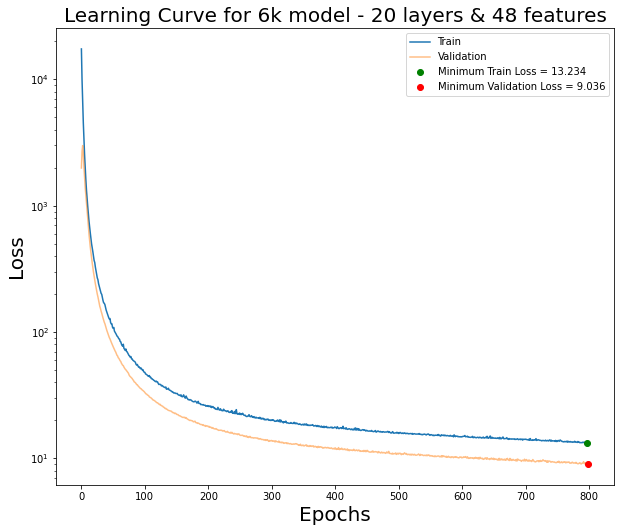

In [17]:
plt.figure(figsize=(10,8.4));
plt.title("Learning Curve for 6k model - 20 layers & 48 features", size=20);
plt.plot(range(800), np.asarray(losses), label="Train");
plt.plot(range(800), np.asarray(val_losses), label="Validation", alpha=0.5);
plt.plot(np.argmin(losses), np.asarray(losses[np.argmin(losses)]), 'go', label='Minimum Train Loss = ' f'{losses[np.argmin(losses)]:.3f}')
plt.plot(np.argmin(val_losses), np.asarray(val_losses[np.argmin(val_losses)]), 'ro', label='Minimum Validation Loss = ' f'{val_losses[np.argmin(val_losses)]:.3f}')
plt.xlabel("Epochs", size=20);
plt.ylabel("Loss", size=20);
plt.yscale('log')
# plt.ylim(0,100);
plt.legend(fontsize=10);
plt.show();

In [ ]:
np.argmin(np.asarray(losses))

In [ ]:
np.argmin((val_losses))

In [18]:
# Saving Models
current_dir = pathlib.Path().resolve()
model_params_path = current_dir / 'Model_params'
assert model_params_path.exists()
name = "6k_model_wb_e800_lys10_32feat.pth"
path = model_params_path / name
torch.save(model.state_dict(), path)
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [15]:
np.argmin(np.asarray(losses))

766

In [16]:
np.argmin((val_losses))

770

In [19]:
best_t = sl.NERSC_save('6k_WB_train_loss_10lys_32feat_800e', losses)
best_v = sl.NERSC_save('6k_WB_val_loss_10lys_32feat_800e', val_losses)

20 layer and 56/58 feature model runs on GPU


20 layer and 60 feature model DOES NOT RUN on 